<b/>Predicting the Spread Cover Rates for NFL teams

<b/>Imports:

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
from bs4 import BeautifulSoup, Comment
from io import StringIO 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold

<b/>IMPORTANT: If running this yourself, profootballreference.com blocks access if you visit the website a certain number of times/it thinks you are web scraping, so I would suggest you avoid running the 2 web scraping cells, as the scraped data is already in the 2 CSV files below these cells.

<b/>Web scraping for team offensive stats:

In [3]:
def offense_team_stats(year):
    url = f'https://www.pro-football-reference.com/years/{year}/index.htm'
    print(f"Fetching data for {year}...")
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to fetch data for {year}")
        return None

    soup = BeautifulSoup(response.content, 'html.parser')

    # Some tables are inside HTML comments
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))

    team_stats_df = None
    for comment in comments:
        if 'team_stats' in comment:
            comment_soup = BeautifulSoup(comment, 'html.parser')
            table = comment_soup.find('table', {'id': 'team_stats'})
            if table:
                df = pd.read_html(StringIO(str(table)))[0]
                df['Season'] = year
                team_stats_df = df
                break

    return team_stats_df

# Scrape for all seasons from 2005 to 2024
all_years_data = []
for year in range(2005, 2025):
    df = offense_team_stats(year)
    if df is not None:
        all_years_data.append(df)
    time.sleep(2) 

# Combine and save
if all_years_data:
    offense_df = pd.concat(all_years_data, ignore_index=True)
    offense_df.to_csv('nfl_team_offensive_stats_2005_2024.csv', index=False)
    print("Data saved to nfl_team_offensive_stats_2005_2024.csv")
else:
    print("No data was scraped.")

Fetching data for 2005...
Fetching data for 2006...
Fetching data for 2007...


KeyboardInterrupt: 

<b/>Web Scraping for team defensive stats:

In [ ]:
def defensive_team_stats(year):
    url = f'https://www.pro-football-reference.com/years/{year}/opp.htm'
    print(f"\nFetching defensive data for {year}...")

    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to fetch defensive data for {year}, Status Code: {response.status_code}")
        return None

    soup = BeautifulSoup(response.content, 'html.parser')

    # Try to find the table directly first
    table = soup.find('table', {'id': 'team_stats'})
    if table:
        print(f"Found table directly for {year}")
        df = pd.read_html(StringIO(str(table)))[0]
        df['Season'] = year
        return df
    else:
        print(f"No direct table found, trying comments for {year}...")

    # If not found, look inside HTML comments
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    print(f"Found {len(comments)} HTML comments for {year}")

    for comment in comments:
        if 'team_stats' in comment:
            print(f"Found team_stats in comment for {year}")
            comment_soup = BeautifulSoup(comment, 'html.parser')
            table = comment_soup.find('table', {'id': 'team_stats'})
            if table:
                df = pd.read_html(StringIO(str(table)))[0]
                df['Season'] = year
                return df

    print(f"No defensive data found for {year}")
    return None

all_def_years_data = []
for year in range(2005, 2025):
    df = defensive_team_stats(year)
    if df is not None:
        all_def_years_data.append(df)
    time.sleep(2)

# Combine and save
if all_def_years_data:
    defense_df = pd.concat(all_def_years_data, ignore_index=True)
    defense_df.to_csv('nfl_team_defensive_stats_2005_2024.csv', index=False)
    print("Defensive data saved to nfl_team_defensive_stats_2005_2024.csv")
else:
    print("No defensive data was scraped.")


<b/>Load all the data:

<b/>IMPORTANT: The data frames change as each cell is executed. If you execute a cell out of order or twice in a row, errors could occur, as you may be trying to operate on a data frame that isn't the one the function expects. If any of these errors occur, restart the program from THIS POINT.

In [24]:
#Only have games from the pas 20 seasons (2005 - 2024)
games = pd.read_csv('spreadspoke_scores_updated.csv')
#Offensive data
raw_offense = pd.read_csv('nfl_team_offensive_stats_2005_2024.csv', header=[0,1])
#Defensive data
raw_defense = pd.read_csv('nfl_team_defensive_stats_2005_2024.csv', header=[0,1])

<b/>Data Cleaning:

In [25]:
#Only games from 2005 and onwards
games = games[games['Season'] >= 2005]

# Custom logic to flatten headers based on first-level context
def custom_flatten(columns):
    new_cols = []
    for col in columns:
        top, bottom = col
        if top.strip() in ['Passing', 'Rushing']:
            new_col = f"{top.strip()}_{bottom.strip()}"
        else:
            new_col = bottom.strip() if bottom else top.strip()
        new_cols.append(new_col)
    return new_cols

# Apply custom header flattening
raw_offense.columns = custom_flatten(raw_offense.columns)
raw_defense.columns = custom_flatten(raw_defense.columns)

# Assign cleaned dataframes
offense_df = raw_offense
defense_df = raw_defense

#Rename Season col
offense_df.rename(columns={offense_df.columns[-1]: 'Season'}, inplace=True)
defense_df.rename(columns={defense_df.columns[-1]: 'Season'}, inplace=True)

#Rename Team col
offense_df = offense_df.rename(columns={'Tm': 'Team'})
defense_df = defense_df.rename(columns={'Tm': 'Team'})

# Convert yard columns to numeric just to be safe
offense_df['PF'] = pd.to_numeric(offense_df['PF'], errors='coerce')
offense_df['Passing_Yds'] = pd.to_numeric(offense_df['Passing_Yds'], errors='coerce')
offense_df['Rushing_Yds'] = pd.to_numeric(offense_df['Rushing_Yds'], errors='coerce')

# Same for defense
defense_df['PA'] = pd.to_numeric(defense_df['PA'], errors='coerce')
defense_df['Passing_Yds'] = pd.to_numeric(defense_df['Passing_Yds'], errors='coerce')
defense_df['Rushing_Yds'] = pd.to_numeric(defense_df['Rushing_Yds'], errors='coerce')

# Convert Season to int
offense_df['Season'] = offense_df['Season'].astype(int)
defense_df['Season'] = defense_df['Season'].astype(int)

# Remove rows where 'Team' contains 'Avg' or equals 'League Total'
offense_df = offense_df[~offense_df['Team'].str.contains('Avg|League Total', na=False)]
defense_df = defense_df[~defense_df['Team'].str.contains('Avg|League Total', na=False)]

#Convert necessary Spread DF columns to numeric
games['score_home'] = pd.to_numeric(games['score_home'], errors='coerce')
games['score_away'] = pd.to_numeric(games['score_away'], errors='coerce')
games['spread_favorite'] = pd.to_numeric(games['spread_favorite'], errors='coerce')

<b/>Make sure team names line up:

In [26]:
# Replace typos and drop 'PICK'
games['Team'] = games['Team'].replace({'NJY': 'NYJ', 'LV': 'LVR'})
games = games[games['Team'] != 'PICK']

#Mappings for offensive and defensive DFs
team_to_abbrev = {
    'Arizona Cardinals': 'ARI',
    'Atlanta Falcons': 'ATL',
    'Baltimore Ravens': 'BAL',
    'Buffalo Bills': 'BUF',
    'Carolina Panthers': 'CAR',
    'Chicago Bears': 'CHI',
    'Cincinnati Bengals': 'CIN',
    'Cleveland Browns': 'CLE',
    'Dallas Cowboys': 'DAL',
    'Denver Broncos': 'DEN',
    'Detroit Lions': 'DET',
    'Green Bay Packers': 'GB',
    'Houston Texans': 'HOU',
    'Indianapolis Colts': 'IND',
    'Jacksonville Jaguars': 'JAX',
    'Kansas City Chiefs': 'KC',
    'Las Vegas Raiders': 'LV',
    'Los Angeles Chargers': 'LAC',
    'Los Angeles Rams': 'LAR',
    'Miami Dolphins': 'MIA',
    'Minnesota Vikings': 'MIN',
    'New England Patriots': 'NE',
    'New Orleans Saints': 'NO',
    'New York Giants': 'NYG',
    'New York Jets': 'NYJ',
    'Philadelphia Eagles': 'PHI',
    'Pittsburgh Steelers': 'PIT',
    'San Francisco 49ers': 'SF',
    'Seattle Seahawks': 'SEA',
    'Tampa Bay Buccaneers': 'TB',
    'Tennessee Titans': 'TEN',
    'Washington Commanders': 'WAS',
    'Washington Football Team': 'WAS',
    'Washington Redskins': 'WAS',
    'Oakland Raiders': 'LV',          # Map old names to modern abbreviations
    'St. Louis Rams': 'LAR',
    'San Diego Chargers': 'LAC'
}
#Apply the mappings 
offense_df['Team'] = offense_df['Team'].map(team_to_abbrev)
defense_df['Team'] = defense_df['Team'].map(team_to_abbrev)

#Mappings for the home_score and away_score in the spreads DF
home_away_to_abbrev = {
    'NE': 'NE',
    'IND': 'IND',
    'BUF': 'BUF',
    'CAR': 'CAR',
    'CLE': 'CLE',
    'MIA': 'MIA',
    'CIN': 'CIN',
    'DET': 'DET',
    'JAX': 'JAX',
    'KC': 'KC',
    'DEN': 'DEN',
    'MIN': 'MIN',
    'NYG': 'NYG',
    'PIT': 'PIT',
    'SD': 'LAC',                      
    'SF': 'SF',
    'Washington Redskins': 'WAS',
    'Washington Football Team': 'WAS',
    'WAS': 'WAS',
    'ATL': 'ATL',
    'ARI': 'ARI',
    'CHI': 'CHI',
    'GB': 'GB',
    'HOU': 'HOU',
    'NYJ': 'NYJ',
    'OAK': 'LVR',                     
    'PHI': 'PHI',
    'SEA': 'SEA',
    'TB': 'TB',
    'TEN': 'TEN',
    'DAL': 'DAL',
    'STL': 'LAR',                     
    'NO': 'NO',
    'LAR': 'LAR',
    'LAC': 'LAC',
    'LV': 'LVR',                      
    'BAL': 'BAL'
}
#Apply the mappings
games['team_home'] = games['team_home'].map(home_away_to_abbrev)
games['team_away'] = games['team_away'].map(home_away_to_abbrev)

<b/> Calculate Spread Cover Rates:

In [27]:
# Calculate the point differential: home - away
games['point_diff'] = games['score_home'] - games['score_away']
# If home team is the favorite:
games['fav_is_home'] = games['team_home'] == games['Team']

# Calculate if favorite covered:
games['favorite_covered'] = games.apply(
    lambda row: (row['point_diff'] > abs(row['spread_favorite'])) if row['fav_is_home']
    else (-row['point_diff'] > abs(row['spread_favorite'])),
    axis=1
)

# Determine which team actually covered:
games['covered_by'] = games.apply(
    lambda row: row['Team'] if row['favorite_covered'] else (row['team_away'] if row['fav_is_home'] else row['team_home']),
    axis=1
)

# Home team games: did they cover?
games['team_home_covered'] = games['covered_by'] == games['team_home']

# Away team games: did they cover?
games['team_away_covered'] = games['covered_by'] == games['team_away']

# Home cover rates per team
home_covers = games.groupby(['team_home', 'Season']).agg(
    Home_Games=('team_home_covered', 'count'),
    Home_Covers=('team_home_covered', 'sum')
).reset_index().rename(columns={'team_home': 'Team'})

home_covers['Home_Cover_Rate'] = home_covers['Home_Covers'] / home_covers['Home_Games']

# Away cover rates per team
away_covers = games.groupby(['team_away', 'Season']).agg(
    Away_Games=('team_away_covered', 'count'),
    Away_Covers=('team_away_covered', 'sum')
).reset_index().rename(columns={'team_away': 'Team'})

away_covers['Away_Cover_Rate'] = away_covers['Away_Covers'] / away_covers['Away_Games']

# Merge the home and away covers
home_away_cover = pd.merge(home_covers, away_covers, on=['Team', 'Season'])

# Optional: Calculate the difference
home_away_cover['Cover_Rate_Diff'] = home_away_cover['Home_Cover_Rate'] - home_away_cover['Away_Cover_Rate']

# Count total games each team played (home + away combined)
all_teams_long = pd.concat([
    games[['team_home', 'Season']].rename(columns={'team_home': 'Team'}),
    games[['team_away', 'Season']].rename(columns={'team_away': 'Team'})
])

team_games = all_teams_long.groupby(['Team', 'Season']).size().reset_index(name='Total_Games')

# Count how many times each team covered
covers = games.groupby(['covered_by', 'Season']).size().reset_index(name='Covers').rename(columns={'covered_by': 'Team'})

# Merge and calculate Cover Rate
cover_df = pd.merge(team_games, covers, on=['Team', 'Season'], how='left').fillna(0)
cover_df['Cover_Rate'] = cover_df['Covers'] / cover_df['Total_Games']

<b/> Stat Merging and further cleaning:

In [28]:
#Megre offensive and defensive stats into one
merged_stats = pd.merge(offense_df, defense_df, on=['Team', 'Season'], suffixes=('_Off', '_Def'))

merged_stats.columns.values[23] = 'PenYds_Off'  
merged_stats.columns.values[51] = 'PenYds_Def'

#Make there be only 1 column for games played
merged_stats = merged_stats.rename(columns={'G_Off': 'G'})
merged_stats = merged_stats.drop(columns=['G_Def'])

#Change stats from season totals to game averages
merged_stats['Yds/G_Off'] = merged_stats['Yds_Off'] / merged_stats['G']
merged_stats['PPG_Off'] = merged_stats['PF'] / merged_stats['G']
merged_stats['TO/G_Off'] = merged_stats['TO_Off'] / merged_stats['G']
merged_stats['PassYPG_Off'] = merged_stats['Passing_Yds_Off'] / merged_stats['G']
merged_stats['PassTD/G_Off'] = merged_stats['Passing_TD_Off'] / merged_stats['G']
merged_stats['RushYPG_Off'] = merged_stats['Rushing_Yds_Off'] / merged_stats['G']
merged_stats['RushTD/G_Off'] = merged_stats['Rushing_TD_Off'] / merged_stats['G']
merged_stats['Pen/G_Off'] = merged_stats['Pen_Off'] / merged_stats['G']
merged_stats['Yds/G_Def'] = merged_stats['Yds_Def'] / merged_stats['G']
merged_stats['PPG_Def'] = merged_stats['PA'] / merged_stats['G']
merged_stats['TO/G_Def'] = merged_stats['TO_Def'] / merged_stats['G']
merged_stats['PassYPG_Def'] = merged_stats['Passing_Yds_Def'] / merged_stats['G']
merged_stats['PassTD/G_Def'] = merged_stats['Passing_TD_Def'] / merged_stats['G']
merged_stats['RushYPG_Def'] = merged_stats['Rushing_Yds_Def'] / merged_stats['G']
merged_stats['RushTD/G_Def'] = merged_stats['Rushing_TD_Def'] / merged_stats['G']
merged_stats['Pen/G_Def'] = merged_stats['Pen_Def'] / merged_stats['G']

# Merge with cover rates
merged_stats = pd.merge(merged_stats, cover_df, on=['Team', 'Season'], how='inner')
cols_to_numeric = ['Passing_Yds_Off', 'Rushing_Yds_Off', 'Passing_Yds_Def', 'Rushing_Yds_Def', 'Cover_Rate']
for col in cols_to_numeric:
    merged_stats[col] = pd.to_numeric(merged_stats[col], errors='coerce')

# Drop rows with missing values
merged_stats = merged_stats.dropna(subset=cols_to_numeric)

print(merged_stats)

     Rk_Off Team     G     PF  Yds_Off  Ply_Off  Y/P_Off  TO_Off  FL_Off  \
0       1.0  SEA  16.0  452.0   5915.0   1020.0      5.8    17.0     7.0   
1       2.0  IND  16.0  439.0   5799.0   1000.0      5.8    19.0     8.0   
2       3.0  NYG  16.0  422.0   5787.0   1055.0      5.5    25.0     8.0   
3       4.0  CIN  16.0  421.0   5730.0   1018.0      5.6    20.0     6.0   
4       5.0  LAC  16.0  418.0   5567.0   1022.0      5.4    28.0    12.0   
..      ...  ...   ...    ...      ...      ...      ...     ...     ...   
615    27.0  TEN  17.0  311.0   5172.0   1032.0      5.0    34.0    13.0   
616    28.0  CHI  17.0  310.0   4820.0   1065.0      4.5    16.0     9.0   
617    30.0   NE  17.0  289.0   4964.0   1027.0      4.8    23.0    12.0   
618    31.0  NYG  17.0  273.0   5011.0   1063.0      4.7    23.0    10.0   
619    32.0  CLE  17.0  258.0   5114.0   1118.0      4.6    34.0    11.0   

     1stD_Off  ...    PPG_Def  TO/G_Def  PassYPG_Def  PassTD/G_Def  \
0       361.0  ..

<b/>EDA/Data Visualization:

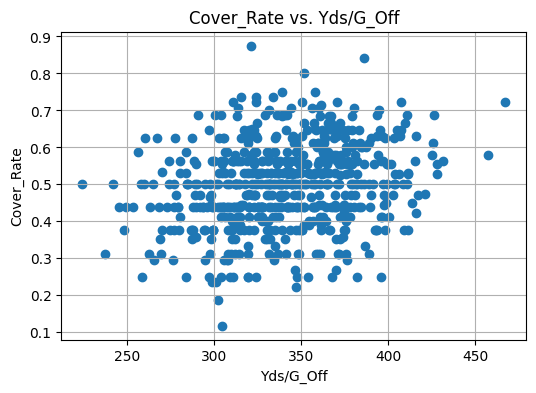

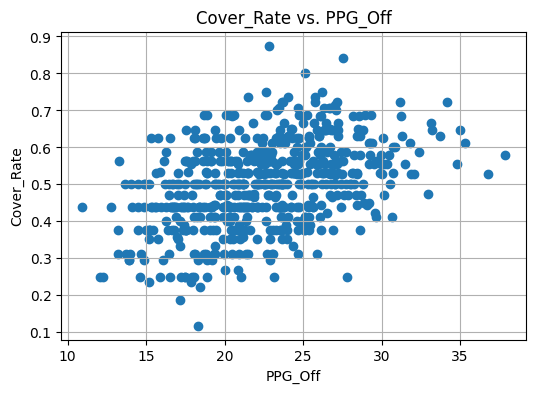

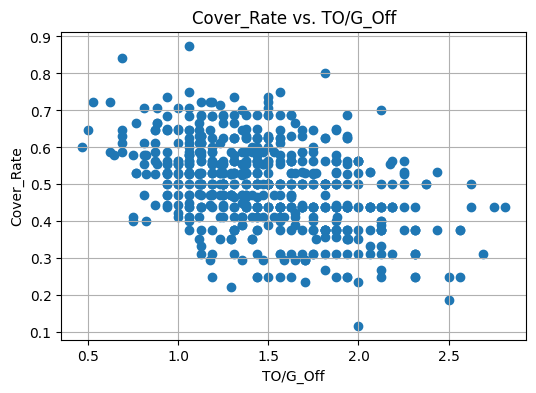

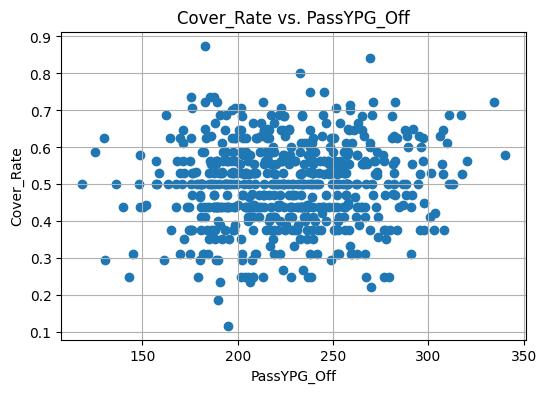

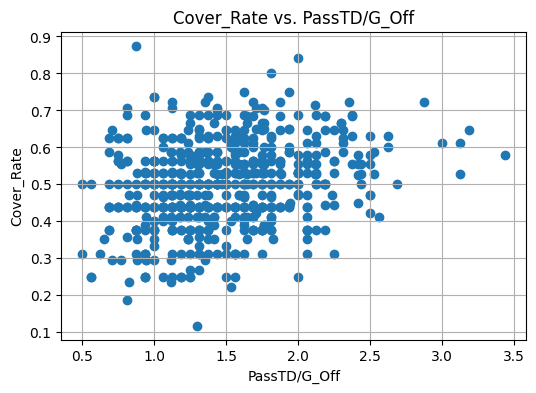

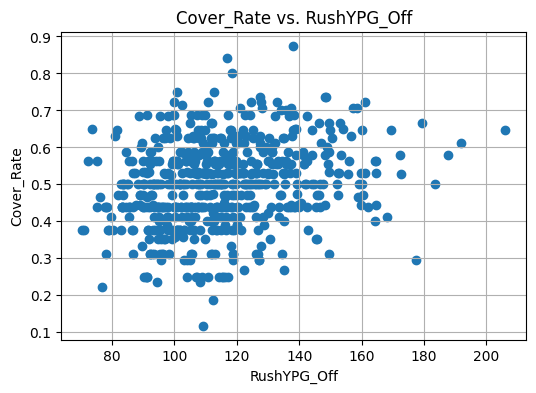

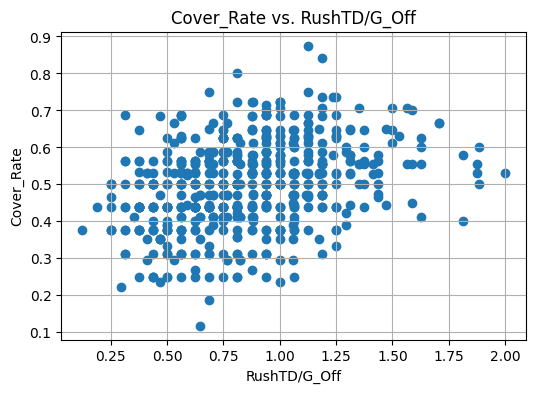

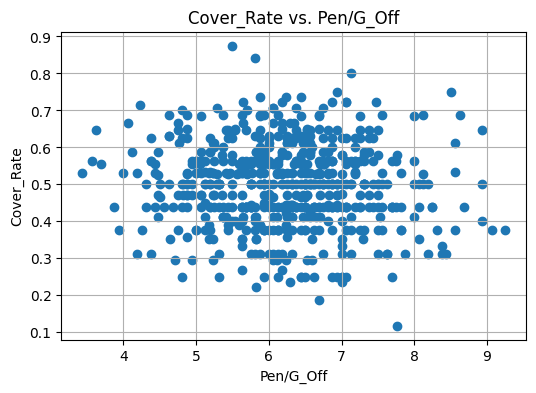

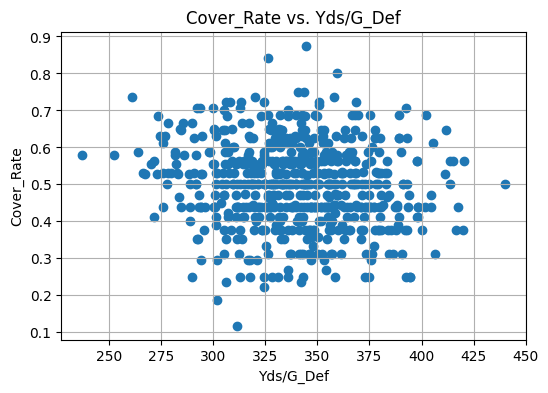

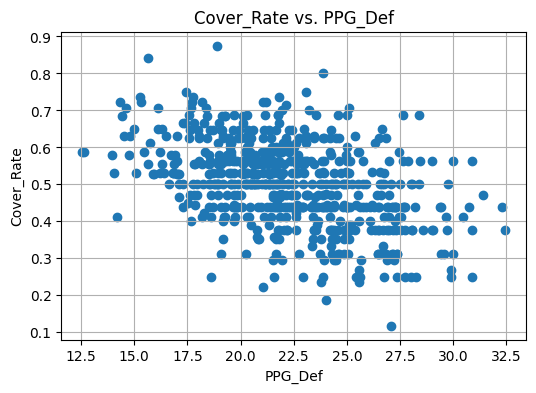

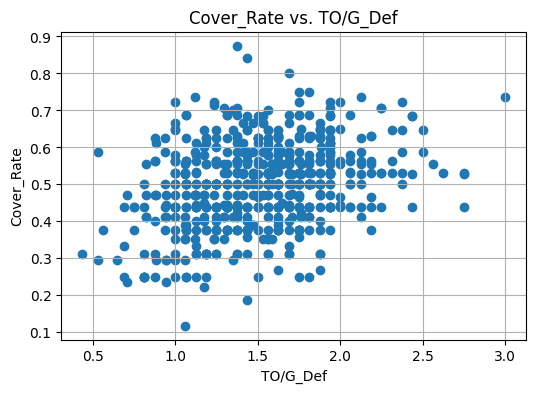

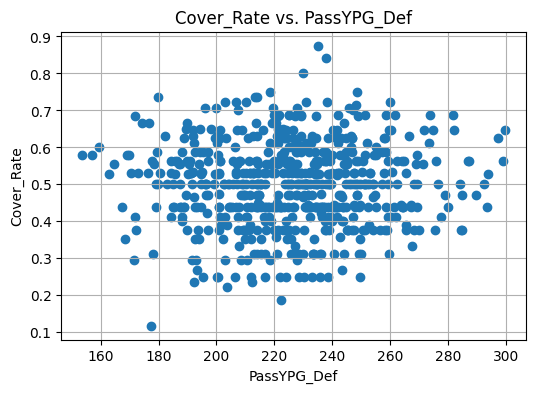

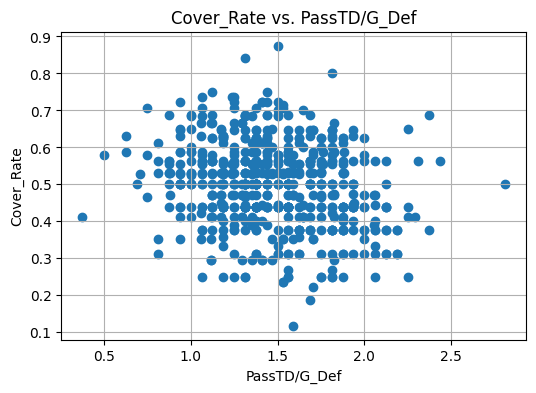

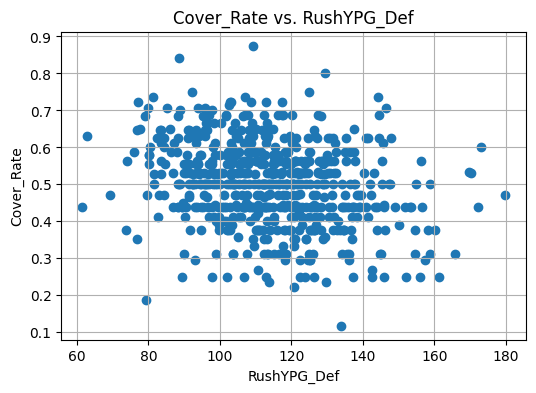

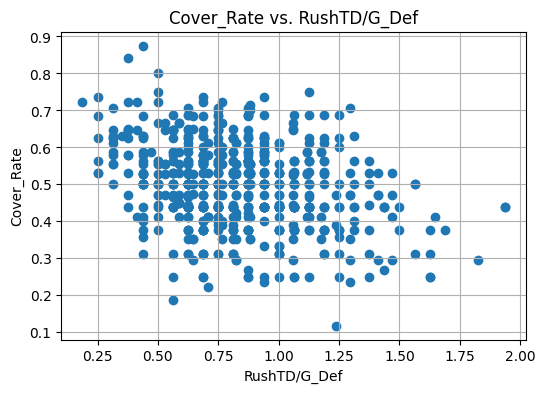

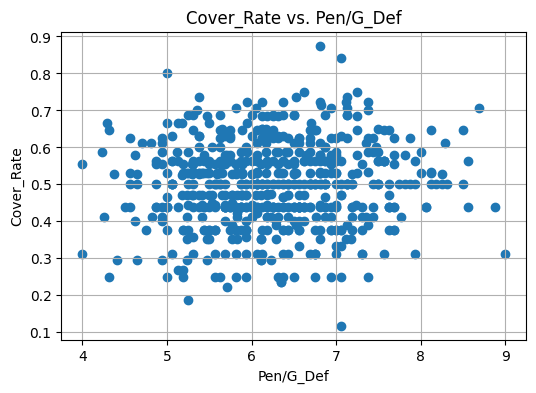

In [29]:
# Columns for EDA
columns_to_plot = [
    'Yds/G_Off', 'PPG_Off', 'TO/G_Off', 'PassYPG_Off', 'PassTD/G_Off',
    'RushYPG_Off', 'RushTD/G_Off', 'Pen/G_Off',
    'Yds/G_Def', 'PPG_Def', 'TO/G_Def', 'PassYPG_Def', 'PassTD/G_Def',
    'RushYPG_Def', 'RushTD/G_Def', 'Pen/G_Def'
]

# Function to plot each feature vs Cover Rate
def plot_scatter_graphs(dataframe, feature_columns, target_column='Cover_Rate'):
    for column in feature_columns:
        if column in dataframe.columns and target_column in dataframe.columns:
            plt.figure(figsize=(6, 4))
            plt.scatter(dataframe[column], dataframe[target_column])
            plt.xlabel(column)
            plt.ylabel(target_column)
            plt.title(f'{target_column} vs. {column}')
            plt.grid(True)
            plt.show()
        else:
            print(f"Skipping {column} (missing in DataFrame)")

# Run it like this:
plot_scatter_graphs(merged_stats, columns_to_plot)

<b/> Correlation Heat Map:

              Yds/G_Off   PPG_Off  TO/G_Off  PassYPG_Off  PassTD/G_Off  \
Yds/G_Off      1.000000  0.839421 -0.300337     0.838918      0.746582   
PPG_Off        0.839421  1.000000 -0.436588     0.656304      0.808809   
TO/G_Off      -0.300337 -0.436588  1.000000    -0.141538     -0.314723   
PassYPG_Off    0.838918  0.656304 -0.141538     1.000000      0.760106   
PassTD/G_Off   0.746582  0.808809 -0.314723     0.760106      1.000000   
RushYPG_Off    0.295212  0.331896 -0.282503    -0.272343     -0.014458   
RushTD/G_Off   0.492253  0.603143 -0.348938     0.129767      0.133718   
Pen/G_Off      0.022387 -0.029429  0.067670     0.064561      0.033175   
Yds/G_Def      0.029929 -0.042669 -0.014593     0.145183      0.096247   
PPG_Def       -0.073045 -0.233161  0.338592     0.077308     -0.045052   
TO/G_Def       0.052212  0.311807  0.007870    -0.006427      0.142651   
PassYPG_Def    0.221620  0.180043 -0.118376     0.264607      0.249658   
PassTD/G_Def   0.157744  0.053412  0.0

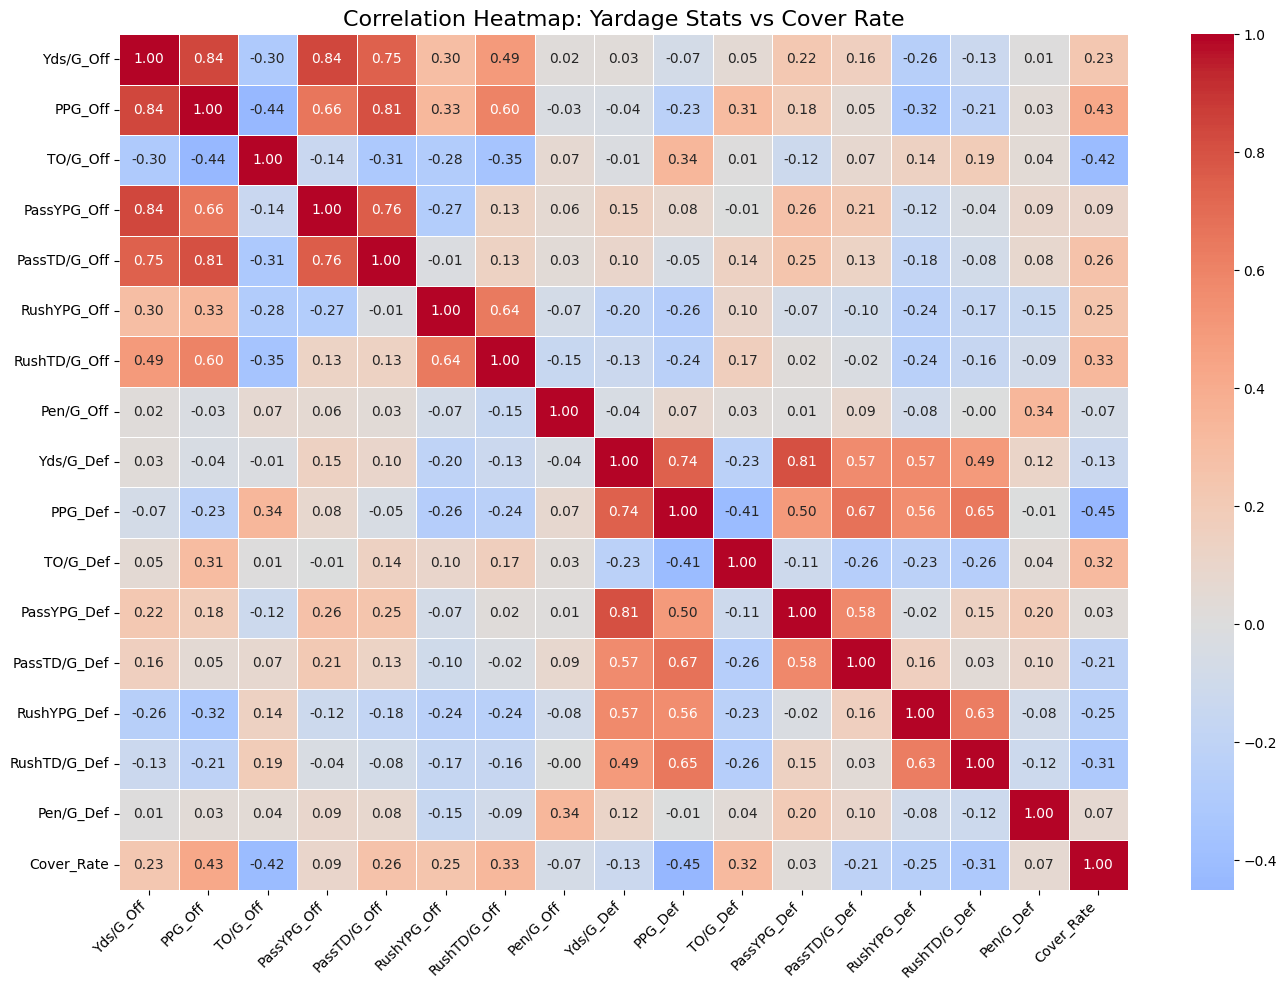

In [30]:
# Only keep relevant numeric columns
corr_columns = ['Yds/G_Off', 'PPG_Off', 'TO/G_Off', 'PassYPG_Off', 'PassTD/G_Off',
    'RushYPG_Off', 'RushTD/G_Off', 'Pen/G_Off',
    'Yds/G_Def', 'PPG_Def', 'TO/G_Def', 'PassYPG_Def', 'PassTD/G_Def',
    'RushYPG_Def', 'RushTD/G_Def', 'Pen/G_Def', 'Cover_Rate']

# Calculate correlation matrix
correlation_matrix = merged_stats[corr_columns].corr()

# Print the matrix
print(correlation_matrix)

plt.figure(figsize=(14, 10))  # <--- Increase width and height

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    fmt=".2f",  # optional: formats numbers to 2 decimal places
    annot_kws={"size": 10}  # optional: smaller/larger font for annotations
)

plt.title('Correlation Heatmap: Yardage Stats vs Cover Rate', fontsize=16)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout()  
plt.show()

<b/> Feature Engineering and Data Normalization:

In [31]:
#Drop some unnecessary columns
columns_to_drop = ['Rk_Off', 'G_Off', 'Rk_Def', 'G_Def', 'Ply_Off', 'Ply_Def', 'FL_Off', 'FL_Def'] 

#Create new features based off some of the statistics with the highest correlations
merged_stats['Net_PPG'] = merged_stats['PPG_Off'] - merged_stats['PPG_Def']
merged_stats['Net_Yards_Per_Game'] = merged_stats['Yds/G_Off'] - merged_stats['Yds/G_Def']
merged_stats['Net_TO_Per_Game'] = merged_stats['TO/G_Def'] - merged_stats['TO/G_Off']
merged_stats['Pass_Efficiency'] = merged_stats['PassTD/G_Off'] / (merged_stats['PassYPG_Off'] + 1)
merged_stats['Rush_Efficiency'] = merged_stats['RushTD/G_Off'] / (merged_stats['RushYPG_Off'] + 1)
merged_stats['Turnover_Margin'] = merged_stats['TO/G_Def'] - merged_stats['TO/G_Off']
merged_stats['Penalty_Differential'] = merged_stats['Pen/G_Def'] - merged_stats['Pen/G_Off']

#Keep the names of the teams in order just in case
teams_in_order = merged_stats['Team']


#Stats for Project Report
above_50_avg = merged_stats.loc[merged_stats['Cover_Rate'] > 0.5, 'Cover_Rate'].mean()
below_equal_50_avg = merged_stats.loc[merged_stats['Cover_Rate'] <= 0.5, 'Cover_Rate'].mean()
print(f"Average Cover_Rate > 50%: {above_50_avg:.4f}")
print(f"Average Cover_Rate <= 50%: {below_equal_50_avg:.4f}")


#Drop team names from DF(not necessary)
merged_stats = merged_stats.drop(columns=['Team'])

#Initializa Scaler
scaler = StandardScaler()

#Select the features to scale
features_to_scale = merged_stats.drop(columns=['Cover_Rate'])

#Scale selected features
scaled_features = scaler.fit_transform(features_to_scale)

# Rebuild a scaled dataframe (optional)
merged_stats_scaled = pd.DataFrame(scaled_features, columns=features_to_scale.columns)
merged_stats_scaled['Cover_Rate'] = merged_stats['Cover_Rate']  # Add back target

Average Cover_Rate > 50%: 0.5979
Average Cover_Rate <= 50%: 0.4175


<b/>Explore Correlations:

In [32]:
#Stats with highest correlations to cover rate (ignore "Covers")
corr_with_target = merged_stats.corr()['Cover_Rate'].drop(['Cover_Rate', 'Covers']).sort_values(key=abs, ascending=False)

#Same for the scaled DF
corr_with_target_scaled = merged_stats_scaled.corr()['Cover_Rate'].drop(['Cover_Rate', 'Covers']).sort_values(key=abs, ascending=False)
#Print stats with the highest correlations (will be the same regardless of scaling)
print(corr_with_target.head(20))

# Get the top 13 correlated stat names (excluding 'Cover_Rate' and 'Covers')
top_features = corr_with_target.head(20).index.tolist()
#Same for scaled
top_scaled_features = corr_with_target_scaled.head(20).index.tolist()

# Filter the original DataFrame to keep only these columns + the target 
filtered_df = merged_stats[top_features + ['Cover_Rate']]

#Same for scaled
filtered_df_scaled = merged_stats_scaled[top_scaled_features + ['Cover_Rate']]

Net_PPG            0.555000
Net_TO_Per_Game    0.525151
Turnover_Margin    0.525151
Rk_Def            -0.456684
PPG_Def           -0.450062
PA                -0.445774
Rk_Off            -0.437848
TO%_Off           -0.435822
TO_Off            -0.427777
PPG_Off            0.427651
PF                 0.424865
TO/G_Off          -0.418090
Sc%_Off            0.389619
Total_Games        0.376834
Passing_Int_Off   -0.370265
Rushing_Att_Def   -0.368866
TO%_Def            0.346896
Sc%_Def           -0.330869
RushTD/G_Off       0.326499
TO_Def             0.325546
Name: Cover_Rate, dtype: float64


<b/>Split data into testing and training sets:

In [33]:
# Separate features and target
X = filtered_df.drop('Cover_Rate', axis=1)
y = (filtered_df['Cover_Rate'] > 0.5).astype(int)  
# Scaled variabled (for Logistic Regression)
sX = filtered_df_scaled.drop('Cover_Rate', axis=1)
sy = (filtered_df_scaled['Cover_Rate'] > 0.5).astype(int)  

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42, stratify=y)
# #Also for scaled
# Split into train and test sets
sX_train, sX_test, sy_train, sy_test = train_test_split(sX, sy, test_size=0.35, random_state=42, stratify=sy)

# Make sure you're seeing this:
print("Test class distribution:", y_test.value_counts())

Test class distribution: Cover_Rate
0    120
1     97
Name: count, dtype: int64


<b/>Build and Evaluate Models:


Random Forest Results:
Accuracy: 0.7235023041474654
MSE: 0.2764976958525346
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       120
           1       0.70      0.67      0.68        97

    accuracy                           0.72       217
   macro avg       0.72      0.72      0.72       217
weighted avg       0.72      0.72      0.72       217



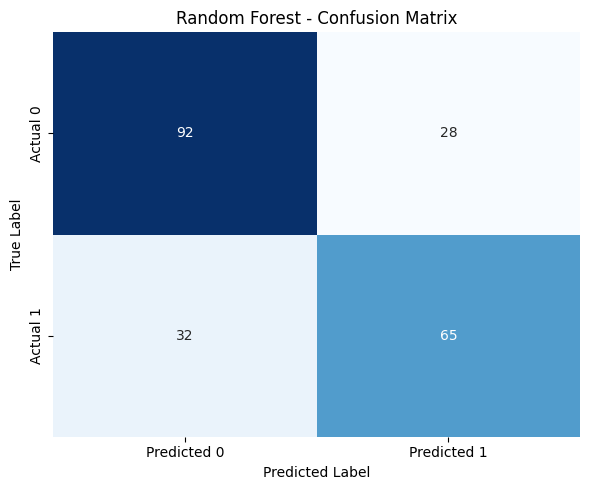

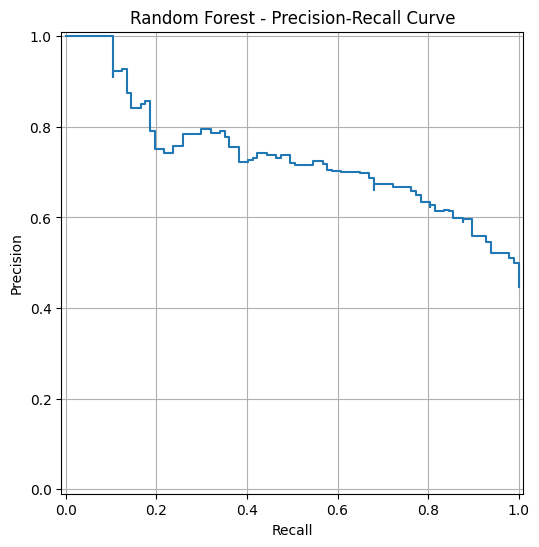


XGBoost Results:
Accuracy: 0.6820276497695853
MSE: 0.31797235023041476
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       120
           1       0.66      0.61      0.63        97

    accuracy                           0.68       217
   macro avg       0.68      0.67      0.68       217
weighted avg       0.68      0.68      0.68       217



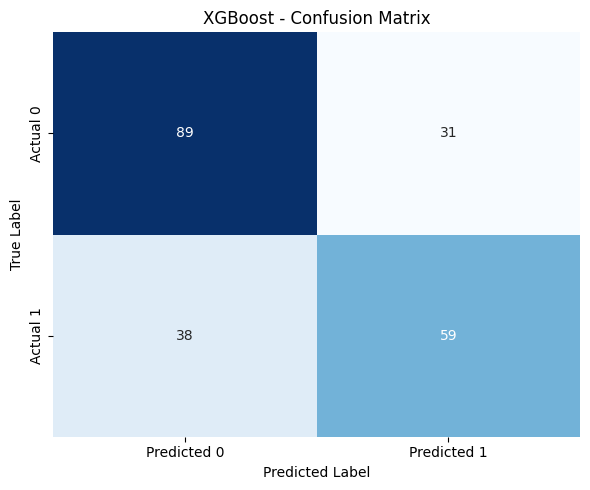

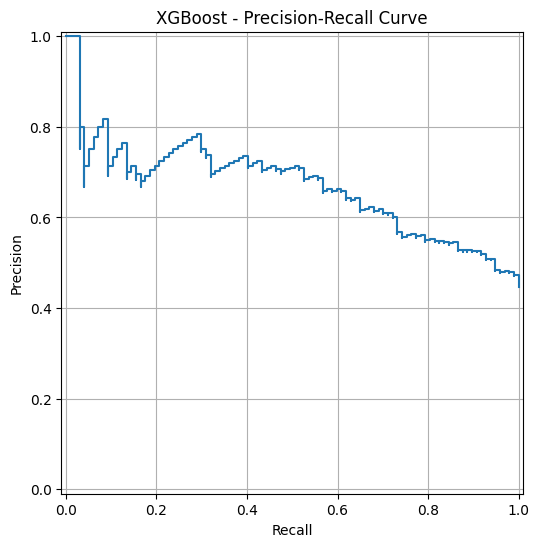


Logistic Regression Results:
Accuracy: 0.7603686635944701
MSE: 0.31797235023041476
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       120
           1       0.76      0.68      0.72        97

    accuracy                           0.76       217
   macro avg       0.76      0.75      0.75       217
weighted avg       0.76      0.76      0.76       217



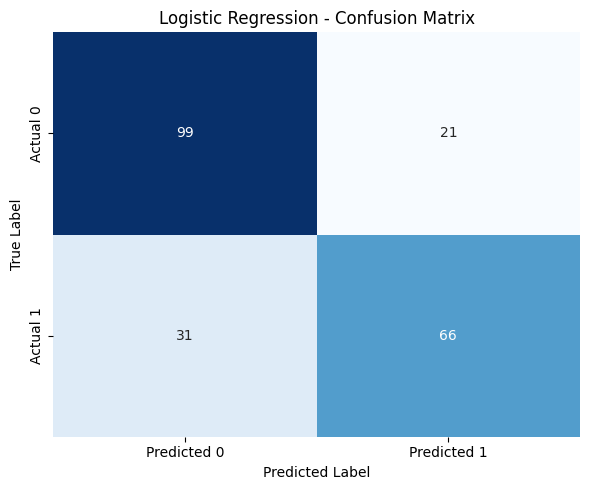

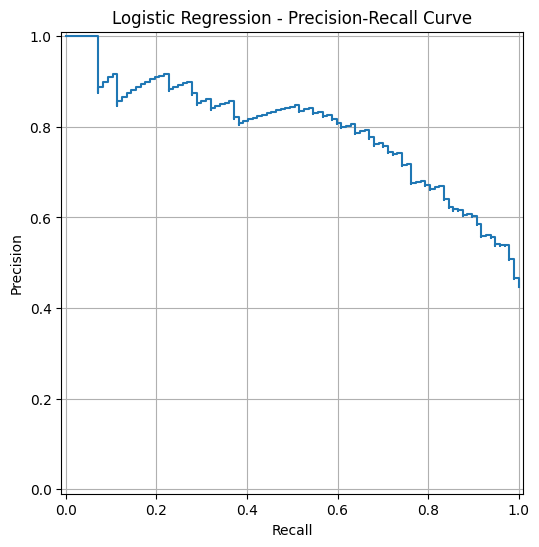


SVM (RBF Kernel) Results:
Accuracy: 0.7649769585253456
MSE: 0.31797235023041476
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       120
           1       0.78      0.66      0.72        97

    accuracy                           0.76       217
   macro avg       0.77      0.75      0.76       217
weighted avg       0.77      0.76      0.76       217



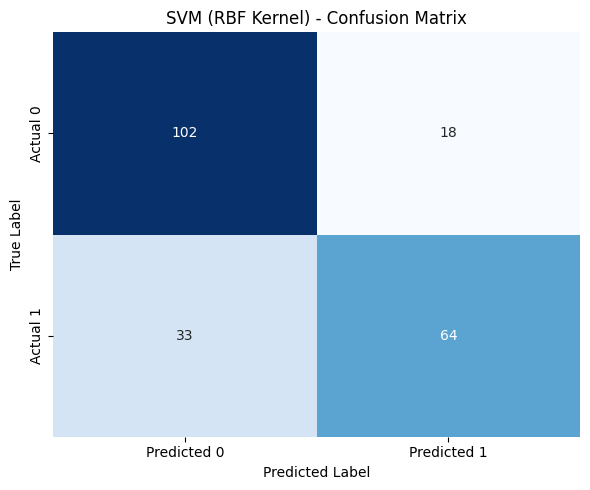

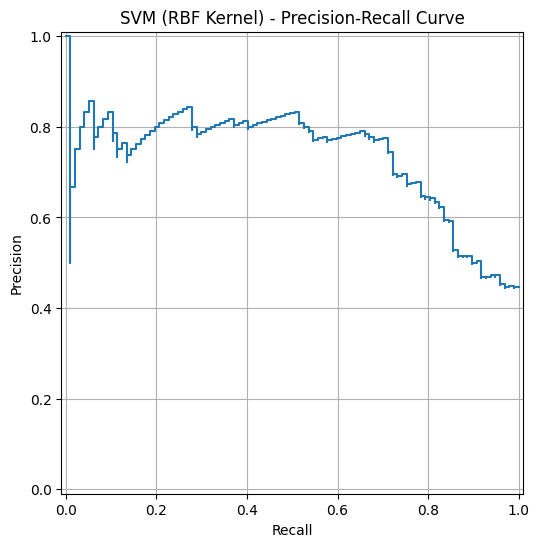

In [34]:
#List of models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{name} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

       # Precision-Recall Curve (only if model supports predict_proba)
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        disp = PrecisionRecallDisplay(precision=precision, recall=recall)
        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(ax=ax)
        plt.title(f"{name} - Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.grid(True)
        plt.show()

#Scaled Models
scaler_models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "SVM (RBF Kernel)": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
}
# Train and evaluate
for name, model in scaler_models.items():
    model.fit(sX_train, sy_train)
    sy_pred = model.predict(sX_test)
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(sy_test, sy_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print(classification_report(sy_test, sy_pred, zero_division=0))

    cm = confusion_matrix(sy_test, sy_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{name} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Precision-Recall Curve (check for predict_proba)
    fitted_model = model.best_estimator_ if hasattr(model, "best_estimator_") else model
    if hasattr(fitted_model, "predict_proba"):
        s_scores = fitted_model.predict_proba(sX_test)[:, 1]
        precision, recall, _ = precision_recall_curve(sy_test, s_scores)
        disp = PrecisionRecallDisplay(precision=precision, recall=recall)
        fig, ax = plt.subplots(figsize=(8, 6))
        disp.plot(ax=ax)
        plt.title(f"{name} - Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.grid(True)
        plt.show()

<b/>Model Interpretation/Feature Importance

In [35]:
#Extract important features
for name, model in models.items():
    if name in ["Random Forest", "XGBoost"]:
        importances = model.feature_importances_
        imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
        imp_df = imp_df.sort_values(by='Importance', ascending=False)

        print(f"\nTop 5 Features by Importance for {name}:")
        print(imp_df.head(5))

        print(f"\nLeast 5 Important Features for {name}:")
        print(imp_df.tail(5))

#Same for scaled models
for name, model in scaler_models.items():
    fitted_model = model.best_estimator_ if hasattr(model, "best_estimator_") else model

    if hasattr(fitted_model, "coef_"):
        coefficients = fitted_model.coef_[0]
        coef_df = pd.DataFrame({
            'Feature': sX.columns,
            'Coefficient': coefficients,
            'Abs_Coefficient': abs(coefficients)
        })

        # Sort by coefficient value
        coef_df_sorted = coef_df.sort_values(by='Coefficient', ascending=False)
        print(f"\n{name} - Top 5 Positive Coefficients (pushing toward class 1):")
        print(coef_df_sorted.head(5))

        print(f"\n{name} - Top 5 Negative Coefficients (pushing toward class 0):")
        print(coef_df_sorted.tail(5))

        # Sort by absolute value to find least influential
        coef_df_least = coef_df.sort_values(by='Abs_Coefficient', ascending=True)
        print(f"\n{name} - 5 Least Important Features (coefficients near 0):")
        print(coef_df_least.head(5))


Top 5 Features by Importance for Random Forest:
            Feature  Importance
0           Net_PPG    0.106195
1   Net_TO_Per_Game    0.074935
2   Turnover_Margin    0.074599
7           TO%_Off    0.067860
17          Sc%_Def    0.059855

Least 5 Important Features for Random Forest:
            Feature  Importance
13      Total_Games    0.036557
19           TO_Def    0.036239
11         TO/G_Off    0.035173
14  Passing_Int_Off    0.030629
8            TO_Off    0.030005

Top 5 Features by Importance for XGBoost:
            Feature  Importance
0           Net_PPG    0.182861
1   Net_TO_Per_Game    0.087840
13      Total_Games    0.058949
10               PF    0.056362
14  Passing_Int_Off    0.054500

Least 5 Important Features for XGBoost:
            Feature  Importance
19           TO_Def    0.035290
18     RushTD/G_Off    0.034430
5                PA    0.031889
8            TO_Off    0.029656
2   Turnover_Margin    0.000000

Logistic Regression - Top 5 Positive Coefficients (

<b/>Refine the model:

In [36]:
# Scaled variabled (for Logistic Regression)
sX = filtered_df_scaled.drop('Cover_Rate', axis=1)
sy = (filtered_df_scaled['Cover_Rate'] > 0.5).astype(int)  

# Split into train and test sets
sX_train, sX_test, sy_train, sy_test = train_test_split(sX, sy, test_size=0.35, random_state=42, stratify=sy)

#Drop some of the low importance features
low_importance_features = ['Sc%_Def', 'Sc%_Off', 'Rushing_Att_Def', 'TO_Off', 'PA']
sX = sX.drop(columns=low_importance_features)

<b/>Plot Regression Learning Curve to find optimal test/training set size:

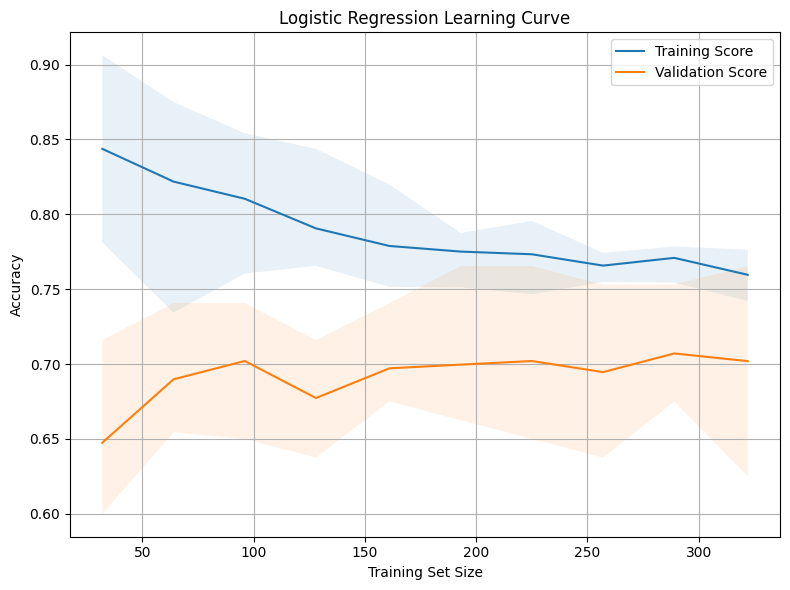

In [37]:
#Model
model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)

#Plot function
def plot_learning_curve(model, X, y, title="Learning Curve", cv_splits=5):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=StratifiedKFold(n_splits=cv_splits), scoring='accuracy', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label="Training Score")
    plt.plot(train_sizes, val_mean, label="Validation Score")
    plt.fill_between(train_sizes, train_scores.min(axis=1), train_scores.max(axis=1), alpha=0.1)
    plt.fill_between(train_sizes, val_scores.min(axis=1), val_scores.max(axis=1), alpha=0.1)

    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(model, sX_train, sy_train, title="Logistic Regression Learning Curve")

In [53]:
#.35 is already pretty optimal for test size, leave as is
sX_train, sX_test, sy_train, sy_test = train_test_split(sX, sy, test_size=0.35, random_state=42, stratify=sy)

<b/>Plot Refined Model:

Model Results:
Accuracy: 0.7649769585253456
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       120
           1       0.78      0.66      0.72        97

    accuracy                           0.76       217
   macro avg       0.77      0.75      0.76       217
weighted avg       0.77      0.76      0.76       217



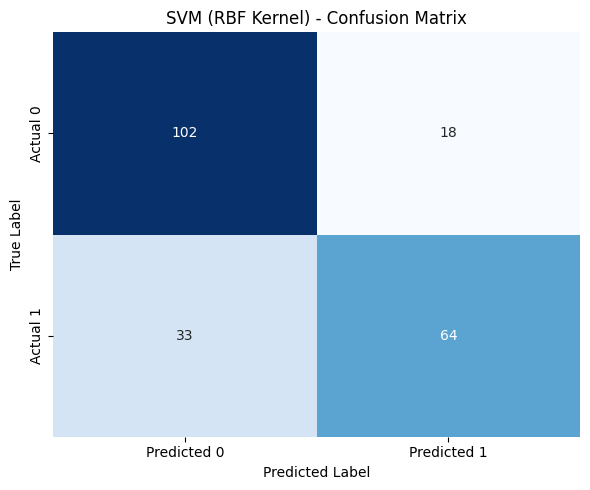

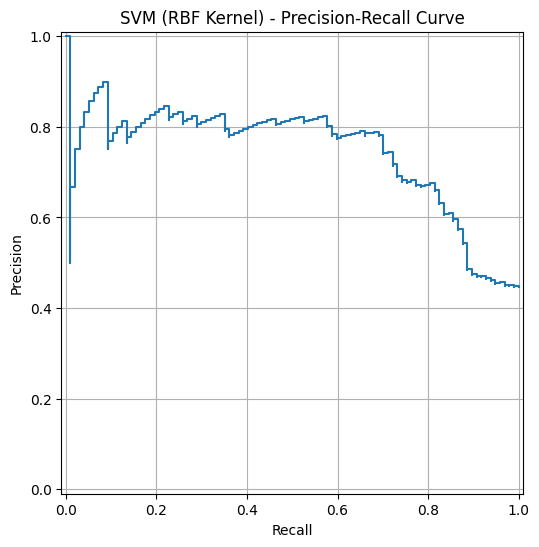

In [54]:
# Train and evaluate
model.fit(sX_train, sy_train)
sy_pred = model.predict(sX_test)
print(f"Model Results:")
print("Accuracy:", accuracy_score(sy_test, sy_pred))
print(classification_report(sy_test, sy_pred, zero_division=0))

cm = confusion_matrix(sy_test, sy_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"{name} - Confusion Matrix")
plt.tight_layout()
plt.show()

# Precision-Recall Curve (check for predict_proba)
fitted_model = model.best_estimator_ if hasattr(model, "best_estimator_") else model
if hasattr(fitted_model, "predict_proba"):
    s_scores = fitted_model.predict_proba(sX_test)[:, 1]
    precision, recall, _ = precision_recall_curve(sy_test, s_scores)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax)
    plt.title(f"{name} - Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()

<b/>END